In [ ]:
# outcome probability model for fastballs

In [39]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import mysql.connector
import pybaseball
from sklearn.metrics import accuracy_score, confusion_matrix

In [87]:
# load in 2022 mlb season data

df = pd.read_csv(r'C:\Users\adam.bloebaum\.vscode\driveline\2022_MLB_Season.csv')

# load in 2023 mlb season data

df_2023 = pd.read_csv(r"C:\Users\adam.bloebaum\.vscode\driveline\2023_MLB_Season.csv")

In [88]:
linear_weights = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\linear_weights.csv")

In [89]:
xpfx_x_2022 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_pfx_x_predictions.csv")
xpfx_z_2022 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2022_pfx_z_predictions.csv")

In [ ]:
xpfx_x_2023 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_pfx_x_predictions.csv")
xpfx_z_2023 = pd.read_csv(r"Y:\departments\research_and_development\baseball_operations\clayton_goodiez\csv\2023_pfx_z_predictions.csv")

In [90]:
# ensure df is sequential

df.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

stand_encoder = LabelEncoder()
all_stand = pd.concat([df['stand'], df_2023['stand']]).unique()
stand_encoder.fit(all_stand)

df['stand'] = stand_encoder.transform(df['stand'])

# generate unique id column

df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + \
                            df['batter'].astype(str) + "_" + \
                            df['pitcher'].astype(str) + "_" + \
                            df['pitch_number'].astype(str) + "_" + \
                            df['at_bat_number'].astype(str) + "_" + \
                            df['inning'].astype(str)

# select only fastballs

df = df[df['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df.loc[df['p_throws'] == 'L', 'pfx_x'] = df['pfx_x'] * -1
df.loc[df['p_throws'] == 'L', 'release_pos_x'] = df['release_pos_x'] * -1
df['spin_axis'] = 360 - df['spin_axis']

# total movement column

df['pfx_total'] = abs(df['pfx_x']) + abs(df['pfx_z'])

# movement ratio column

df['pfx_x_ratio'] = abs(df['pfx_x']) / df['pfx_total']
df['pfx_z_ratio'] = abs(df['pfx_z']) / df['pfx_total']

In [91]:
# ensure df is sequential

df_2023.sort_values(by=['game_pk', 'inning', 'at_bat_number', 'pitch_number'], inplace=True)

# convert batter handedness columns to binary

df_2023['stand'] = stand_encoder.transform(df_2023['stand'])

# generate unique id column

df_2023['pitch_id_raw'] = df_2023['game_pk'].astype(str) + "_" + \
                            df_2023['batter'].astype(str) + "_" + \
                            df_2023['pitcher'].astype(str) + "_" + \
                            df_2023['pitch_number'].astype(str) + "_" + \
                            df_2023['at_bat_number'].astype(str) + "_" + \
                            df_2023['inning'].astype(str)

# select only fastballs

df_2023 = df_2023[df_2023['pitch_type'].isin(['FF', 'SI', 'FC', 'FA', 'FT'])]

# normalize LHP values to RHP standards

df_2023.loc[df_2023['p_throws'] == 'L', 'pfx_x'] = df_2023['pfx_x'] * -1
df_2023.loc[df_2023['p_throws'] == 'L', 'release_pos_x'] = df_2023['release_pos_x'] * -1
df_2023['spin_axis'] = 360 - df['spin_axis']

# total movement column

df_2023['pfx_total'] = abs(df_2023['pfx_x']) + abs(df_2023['pfx_z'])

# movement ratio column

df_2023['pfx_x_ratio'] = abs(df_2023['pfx_x']) / df_2023['pfx_total']
df_2023['pfx_z_ratio'] = abs(df_2023['pfx_z']) / df_2023['pfx_total']

In [93]:
print(linear_weights)
print(df['description'].unique())
print(df['events'].unique())

    Unnamed: 0         description  linear_weight
0            0                ball       0.046350
1            1  caught_stealing_2b      -0.246377
2            2              double       0.753249
3            3         double_play      -0.773110
4            4           field_out      -0.217943
5            5                foul      -0.037243
6            6            home_run       1.368162
7            7              single       0.467429
8            8              strike      -0.052630
9            9           strikeout      -0.215231
10          10              triple       1.097815
11          11                walk       0.236323
['ball' 'called_strike' 'foul' 'hit_into_play' 'swinging_strike'
 'foul_tip' 'hit_by_pitch' 'blocked_ball' 'missed_bunt' 'foul_bunt'
 'swinging_strike_blocked' 'bunt_foul_tip']
[nan 'field_out' 'double' 'single' 'walk' 'strikeout' 'hit_by_pitch'
 'home_run' 'force_out' 'caught_stealing_2b' 'grounded_into_double_play'
 'sac_fly' 'field_error' 'doubl

In [75]:
# create outcome column using events and description columns

# cs, 1b, 2b, 3b, hr, dp, fo, so, bb

events_mapping = {
    'field_out': 'field_out',
    'force_out': 'field_out',
    'fields_choice_out': 'field_out',
    'fielders_choice': 'field_out',
    'other_out': 'field_out',
    'sac_fly': 'field_out',
    'sac_bunt': 'field_out',
    'walk': 'walk',
    'hit_by_pitch': 'walk',
    'strikeout': 'strikeout',
    'grounded_into_double_play': 'double_play',
    'double_play': 'double_play',
    'strikeout_double_play': 'double_play',
    'sac_fly_double_play': 'double_play',
    'single': 'single',
    'double': 'double',
    'triple': 'triple',
    'home_run': 'home_run'    
}


description_mapping = {
    'ball': 'ball',
    'called_strike': 'strike',
    'foul': 'foul',
    'hit_into_play': 'hit_into_play',
    'swinging_strike': 'strike',
    'foul_tip': 'foul',
    'hit_by_pitch': 'walk',
    'blocked_ball': 'ball' ,
    'missed_bunt': 'strike',
    'foul_bunt': 'foul',
    'swinging_strike_blocked': 'strike',
    'bunt_foul_tip': 'foul'
}

#description_mapping = {
#    'ball': 'ball',
#    'hit_by_pitch': 'ball',
#    'blocked_ball': 'ball',
#    'swinging_strike': 'strike',
#    'missed_bunt': 'strike',
#    'swinging_strike_blocked': 'strike',
#    'foul_bunt': 'strike',
#    'foul': 'strike',
#    'foul_tip': 'strike',
#    'bunt_foul_tip': 'strike',
#    'called_strike': 'strike'
#}

#events_mapping = {
#    'fielders_choice': 'out',
#    'field_out': 'out',
#    'force_out': 'out',
#    'field_error': 'out',
#    'grounded_into_double_play': 'out',
#    'sac_fly': 'out',
#    'fielders_choice_out': 'out',
#    'sac_bunt': 'out',
#    'double_play': 'out',
#    'sac_fly_double_play': 'out',
#    'other_out': 'out',
#    'single': 'single',
#    'double': 'double',
#    'triple': 'triple',
#    'home_run': 'home_run'
#}

# 2022 mapping

df['outcome'] = np.where(
    df['description'] != 'hit_into_play',
    df['description'].map(description_mapping),
    df['events'].map(events_mapping)
)

df.dropna(subset=['outcome'], inplace=True)

# 2023 mapping

df_2023['outcome'] = np.where(
    df_2023['description'] != 'hit_into_play',
    df_2023['description'].map(description_mapping),
    df_2023['events'].map(events_mapping)
)

df_2023.dropna(subset=['outcome'], inplace=True)

outcome_encoder = LabelEncoder()
all_outcome = pd.concat([df['outcome'], df_2023['outcome']]).unique()
outcome_encoder.fit(all_outcome)

df['outcome'] = outcome_encoder.transform(df['outcome'])
df_2023['outcome'] = outcome_encoder.transform(df_2023['outcome'])


In [ ]:
def determine_outcome(row):
    
    event = row['events']
    description = row['description']
    
    if event in events_mapping:
        return events_mapping[event]

    elif description in description_mapping:
        return description_mapping[description]

    else:
        return np.nan

# Apply the function to each row
df['outcome'] = df.apply(determine_outcome, axis=1)

In [ ]:
# Perform the left joins

df = pd.merge(df, xpfx_x_2022, on='pitch_id', how='left')
df = pd.merge(df, xpfx_z_2022, on='pitch_id', how='left')

# Perform the left joins

df_2023 = pd.merge(df_2023, xpfx_x_2023, on='pitch_id', how='left')
df_2023 = pd.merge(df_2023, xpfx_z_2023, on='pitch_id', how='left')

In [76]:
# feature selection and data splitting

features = ['pfx_x_cor', 'pfx_x_predicted', 'pfx_x_diff', 'pfx_x_diff_abs', 'release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'release_extension', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'pfx_total', 'pfx_x_ratio', 'pfx_z_ratio']

# copy and keep only features

df_2023_features = df_2023[features]

# create features and targets

X = df[features]
y = df['outcome']

# train valid test split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# set up model

model = xgb.XGBClassifier(objective='multi:softmax', num_class=9, eval_metric='mlogloss', use_label_encoder=False)

# train model

model.fit(X_train, y_train)

c:\Users\adam.bloebaum\AppData\Local\miniconda3\envs\driveline\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_class=9, num_parallel_tree=None, objective='multi:softmax', ...)

In [78]:
# make predictions

y_pred = model.predict(X_valid)

# evaluate the model

accuracy = accuracy_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

Accuracy: 0.4817539585870889
Confusion Matrix:
[[  591     0     1     7     0 13227     0]
 [   16     0     0     0     0   462     0]
 [    9     0     0     0     0   315     0]
 [  196     0     0     1     0  4767     0]
 [   55     0     0     0     0  1517     0]
 [  648     0     0     8     1 19184     0]
 [    5     0     0     0     0    40     0]]


<Figure size 1000x2000 with 0 Axes>

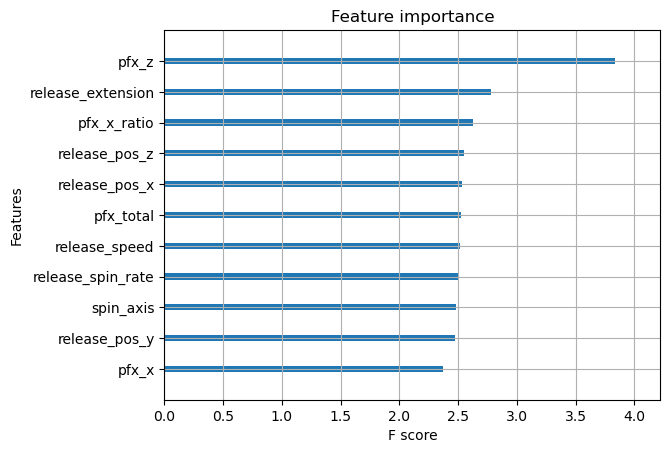

In [79]:
# plot feature importances

plt.figure(figsize=(10, 20))
xgb.plot_importance(model, max_num_features=None, importance_type='gain', show_values=False)
plt.savefig('feature_importance.png')
plt.show()

In [80]:
# get feature importance dictionary

importance = model.get_booster().get_score(importance_type='gain')

# sort features by importance

sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

# loop to print

for feature, score in sorted_importance:
    print(f'{feature}: {score}')

pfx_z: 3.8374860286712646
release_extension: 2.7826929092407227
pfx_x_ratio: 2.62615704536438
release_pos_z: 2.5525944232940674
release_pos_x: 2.5304975509643555
pfx_total: 2.5243847370147705
release_speed: 2.5163307189941406
release_spin_rate: 2.4986565113067627
spin_axis: 2.4824411869049072
release_pos_y: 2.4739601612091064
pfx_x: 2.3713014125823975


In [82]:
# generate outcome probabilities on 2023 mlb season data

outcome_probabilities = model.predict_proba(df_2023_features)

# apply outcome probabilities back onto full df

for i, class_label in enumerate(model.classes_):
    df_2023[f'prob_{class_label}'] = outcome_probabilities[:, i]

In [83]:
label_mapping = dict(zip(outcome_encoder.classes_, outcome_encoder.transform(outcome_encoder.classes_)))
print(label_mapping)

{'ball': 0, 'double': 1, 'home_run': 2, 'out': 3, 'single': 4, 'strike': 5, 'triple': 6}


In [ ]:
# for each outcome columns: mean rv of outcome * outcome probability
# aggregate by pitcher and pitch type
# rank